In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from prophet import Prophet
import xgboost as xgb


In [24]:
#!conda install prophet -y

In [25]:
full_data=pd.read_csv(r"..\data\GlobalLandTemperaturesByCountry.csv")

In [26]:
display(full_data.shape, full_data.head)

(577462, 4)

<bound method NDFrame.head of                 dt  AverageTemperature  AverageTemperatureUncertainty  \
0       1743-11-01               4.384                          2.294   
1       1743-12-01                 NaN                            NaN   
2       1744-01-01                 NaN                            NaN   
3       1744-02-01                 NaN                            NaN   
4       1744-03-01                 NaN                            NaN   
...            ...                 ...                            ...   
577457  2013-05-01              19.059                          1.022   
577458  2013-06-01              17.613                          0.473   
577459  2013-07-01              17.000                          0.453   
577460  2013-08-01              19.759                          0.717   
577461  2013-09-01                 NaN                            NaN   

         Country  
0          Åland  
1          Åland  
2          Åland  
3          Åland 

In [27]:
# Convert the "date" column to a datetime format
full_data.loc[:, 'date'] = pd.to_datetime(full_data['dt'])

# Extract the year from the "date" column and create a new "year" column
full_data.loc[:, 'year'] = full_data['date'].dt.year

In [28]:
full_data.dropna(subset=['AverageTemperature'], inplace=True)
full_data.drop(columns=["dt","AverageTemperatureUncertainty"], inplace=True)

In [29]:
full_data.columns = ["AverageTemperature","country","date","year"]

In [30]:
    # Group the data by "country" and "year" and calculate the annual maximum temperature
max_temp = full_data.groupby(['country', 'year'])['AverageTemperature'].max().reset_index()
max_temp.rename(columns={'AverageTemperature': 'HighestTemperature'}, inplace=True)

In [31]:
    # Group the data by "country" and "year" and calculate the annual minimum temperature
min_temp = full_data.groupby(['country', 'year'])['AverageTemperature'].min().reset_index()
min_temp.rename(columns={'AverageTemperature': 'LowestTemperature'}, inplace=True)


In [32]:
# Group the data by "country" and "year" and calculate the annual average temperature
avg_temp = full_data.groupby(['country', 'year'])['AverageTemperature'].mean().reset_index()
avg_temp.rename(columns={'AverageTemperature': 'AnnualAverageTemperature'}, inplace=True)


In [33]:
    # Merge the three DataFrames on "country" and "year"
result = pd.merge(max_temp, min_temp, on=['country', 'year'])
result = pd.merge(result, avg_temp, on=['country', 'year'])

In [34]:
full_data.head

<bound method NDFrame.head of         AverageTemperature   country       date  year
0                    4.384     Åland 1743-11-01  1743
5                    1.530     Åland 1744-04-01  1744
6                    6.702     Åland 1744-05-01  1744
7                   11.609     Åland 1744-06-01  1744
8                   15.342     Åland 1744-07-01  1744
...                    ...       ...        ...   ...
577456              21.142  Zimbabwe 2013-04-01  2013
577457              19.059  Zimbabwe 2013-05-01  2013
577458              17.613  Zimbabwe 2013-06-01  2013
577459              17.000  Zimbabwe 2013-07-01  2013
577460              19.759  Zimbabwe 2013-08-01  2013

[544811 rows x 4 columns]>

In [35]:
result.head

<bound method NDFrame.head of            country  year  HighestTemperature  LowestTemperature  \
0      Afghanistan  1838              26.877              7.475   
1      Afghanistan  1840              27.739              0.735   
2      Afghanistan  1841              27.104             -0.883   
3      Afghanistan  1842              25.798              3.330   
4      Afghanistan  1843              26.748              0.674   
...            ...   ...                 ...                ...   
45910        Åland  2009              16.423             -2.544   
45911        Åland  2010              19.119             -6.416   
45912        Åland  2011              18.003             -6.390   
45913        Åland  2012              16.050             -3.454   
45914        Åland  2013              16.447             -4.779   

       AnnualAverageTemperature  
0                     18.379571  
1                     13.413455  
2                     13.997600  
3                     15.1546

In [36]:
# List of countries to include in the plot
column_names = ["country","year",'highest_temperature', 'lowest_temperature', 'annual_average_temperature']
temperature_categories = {
    'highest_temperature': 'red',
    'lowest_temperature': 'blue',
    'annual_average_temperature': 'green'
}
categories_to_plot = ['highest_temperature', 'lowest_temperature', 'annual_average_temperature']
country_list = ['Ukraine', 'Germany', 'France']


In [37]:
result.columns=column_names
display(result.head)

<bound method NDFrame.head of            country  year  highest_temperature  lowest_temperature  \
0      Afghanistan  1838               26.877               7.475   
1      Afghanistan  1840               27.739               0.735   
2      Afghanistan  1841               27.104              -0.883   
3      Afghanistan  1842               25.798               3.330   
4      Afghanistan  1843               26.748               0.674   
...            ...   ...                  ...                 ...   
45910        Åland  2009               16.423              -2.544   
45911        Åland  2010               19.119              -6.416   
45912        Åland  2011               18.003              -6.390   
45913        Åland  2012               16.050              -3.454   
45914        Åland  2013               16.447              -4.779   

       annual_average_temperature  
0                       18.379571  
1                       13.413455  
2                       13.997600

In [45]:
def remove_outliers(df, country_list, temperature_categories):
    united_data = pd.DataFrame()
    for country in country_list:
        for category in temperature_categories:
            q1 = df[(df['country'] == country)][category].quantile(0.25)
            q3 = df[(df['country'] == country)][category].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            country_data = df[(df['country'] == country) & (df[category] >= lower_bound) & (df[category] <= upper_bound)]
            united_data = pd.concat([united_data, country_data])
    return united_data


In [46]:
united_data = remove_outliers(result, country_list, categories_to_plot)


In [94]:
def box_plots(df, temperature_categories, country_list):
    sns.set(style="whitegrid")

    # Create subplots to arrange box plots vertically
    fig, axes = plt.subplots(nrows=len(temperature_categories), ncols=1, figsize=(10, 4 * len(temperature_categories)))

    for i, category in enumerate(temperature_categories):
        ax = axes[i]
        ax.set_title(f'{category} by Country')
        sns.boxplot(x='country', y=category, data=df, palette='Set2', ax=ax)
        ax.set_ylabel(category)  # Set y-axis label for the current category

    plt.tight_layout()

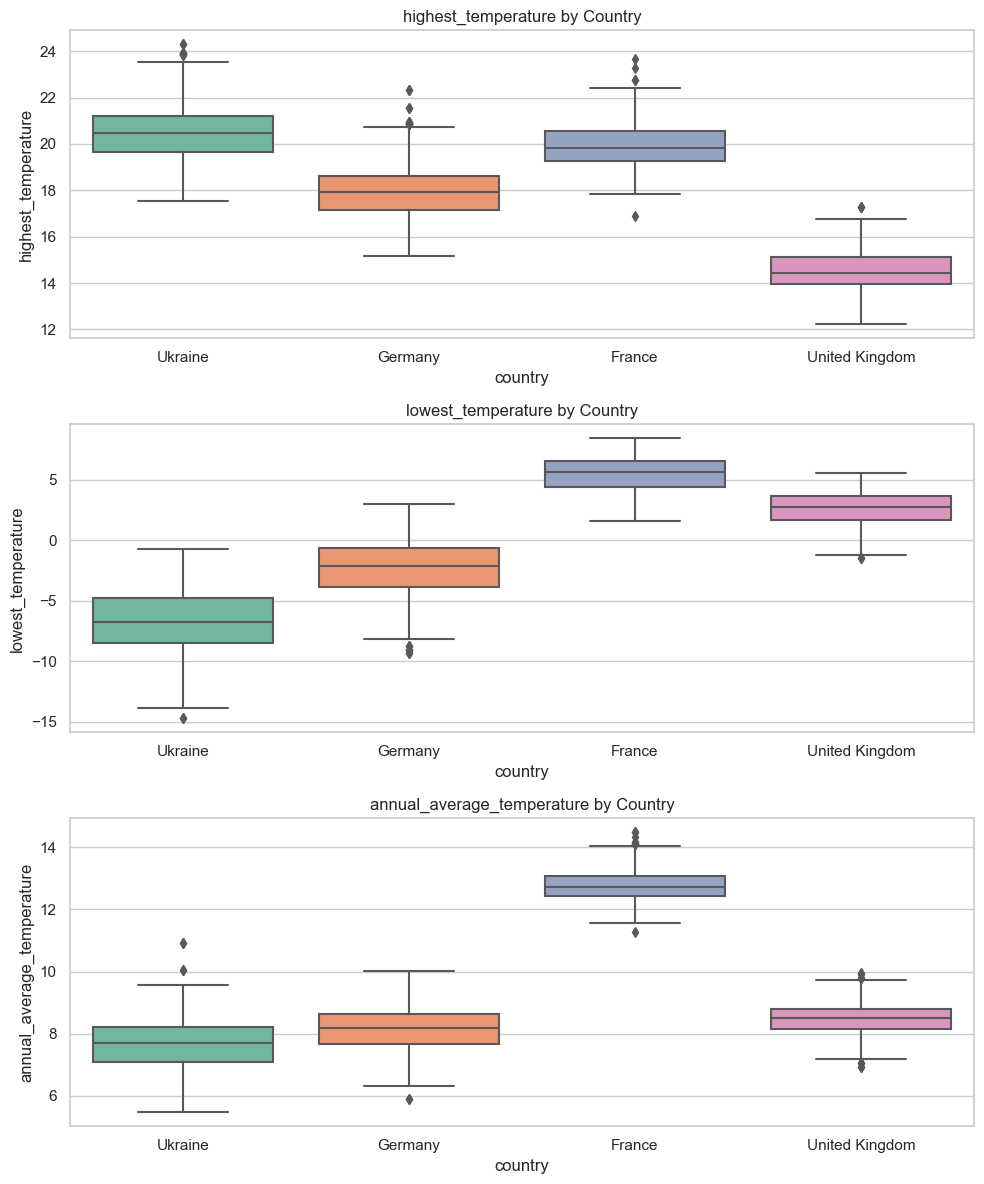

In [95]:
box_plots(united_data, temperature_categories, country_list)

In [59]:
def country_plotter(df, temperature_categories, country_list):
    # Create scatter plots and trendlines for each category on the same plot, one plot per country
    sns.set(style="whitegrid")
    categories_to_plot = list(temperature_categories.keys())
    
    num_countries = len(country_list)
    
    for country in country_list:
        plt.figure(figsize=(10, 4))  # Reduce the figure size to fit in two columns
        plt.title(f'Temperature Trends for {country}')
        
        for category, color in temperature_categories.items():
            country_data = df[df['country'] == country]
            sns.scatterplot(x='year', y=category, data=country_data, label=f'{category}', color=color)
            sns.regplot(x='year', y=category, data=country_data, color=color, scatter=False)
        
        plt.legend(loc='best')
        plt.tight_layout()
    
    plt.show()

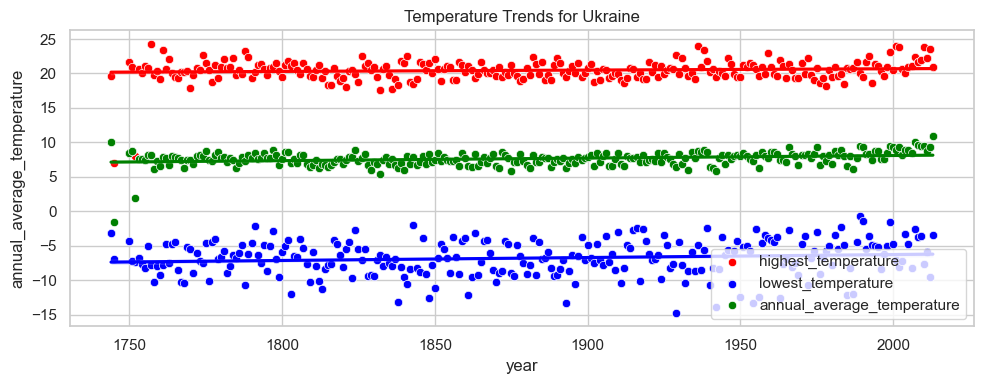

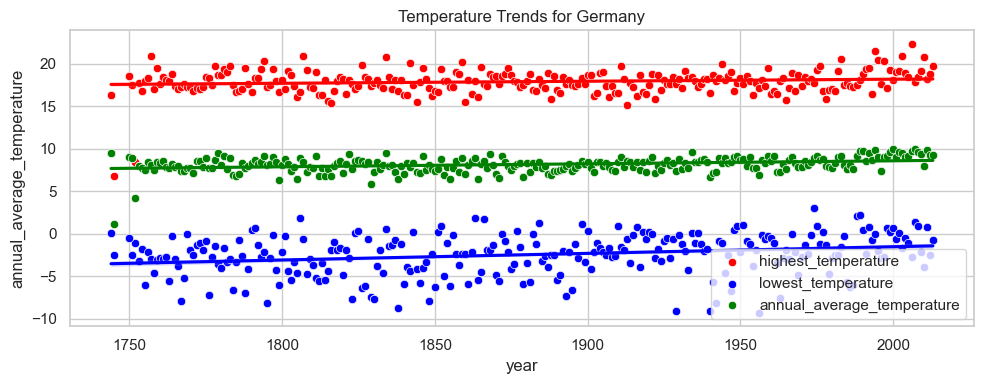

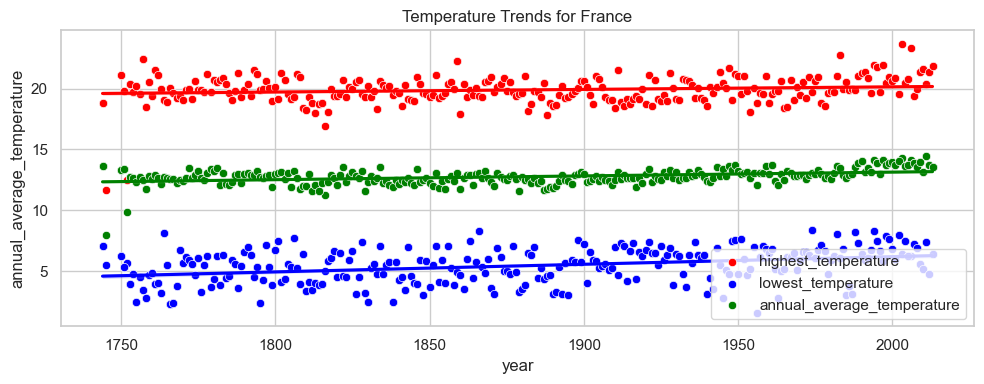

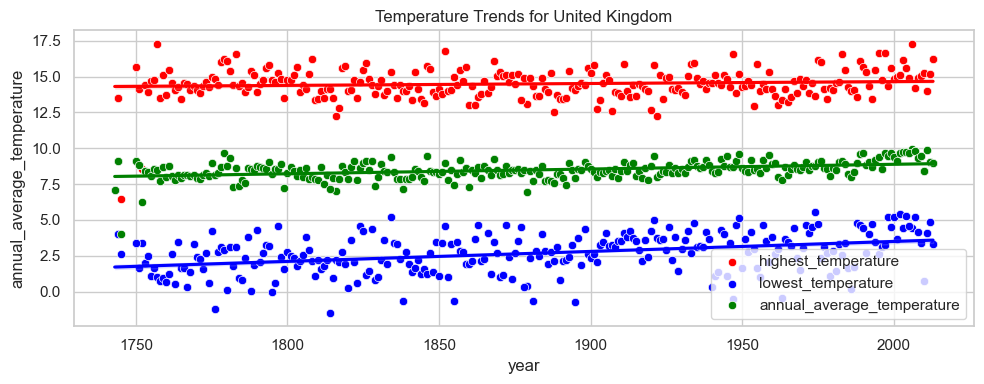

In [60]:
country_plotter(united_data, temperature_categories, country_list)

In [54]:
def country_plotter(df, temperature_categories, country_list, figure_size=(10, 4)):
    # Create scatter plots and trendlines for each category on the same plot, one plot per country
    sns.set(style="whitegrid")
    categories_to_plot = list(temperature_categories.keys())
    
    num_countries = len(country_list)
    num_cols = 2  # Number of columns for subplots
    num_rows = (num_countries + 1) // 2  # Calculate the number of rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figure_size)
    fig.suptitle('Temperature Trends')

    for i, country in enumerate(country_list):
        row = i // 2
        col = i % 2
        ax = axes[row, col]

        for category, color in temperature_categories.items():
            country_data = df[df['country'] == country]
            sns.scatterplot(x='year', y=category, data=country_data, label=f'{category}', color=color, ax=ax)
            sns.regplot(x='year', y=category, data=country_data, color=color, scatter=False, ax=ax)

        ax.set_title(f'{country}')
        ax.legend(loc='best')
        ax.set_xlabel('Year')
        ax.set_ylabel('Temperature')

    # Hide any unused subplots
    for i in range(len(country_list), num_rows * num_cols):
        row = i // 2
        col = i % 2
        fig.delaxes(axes[row, col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


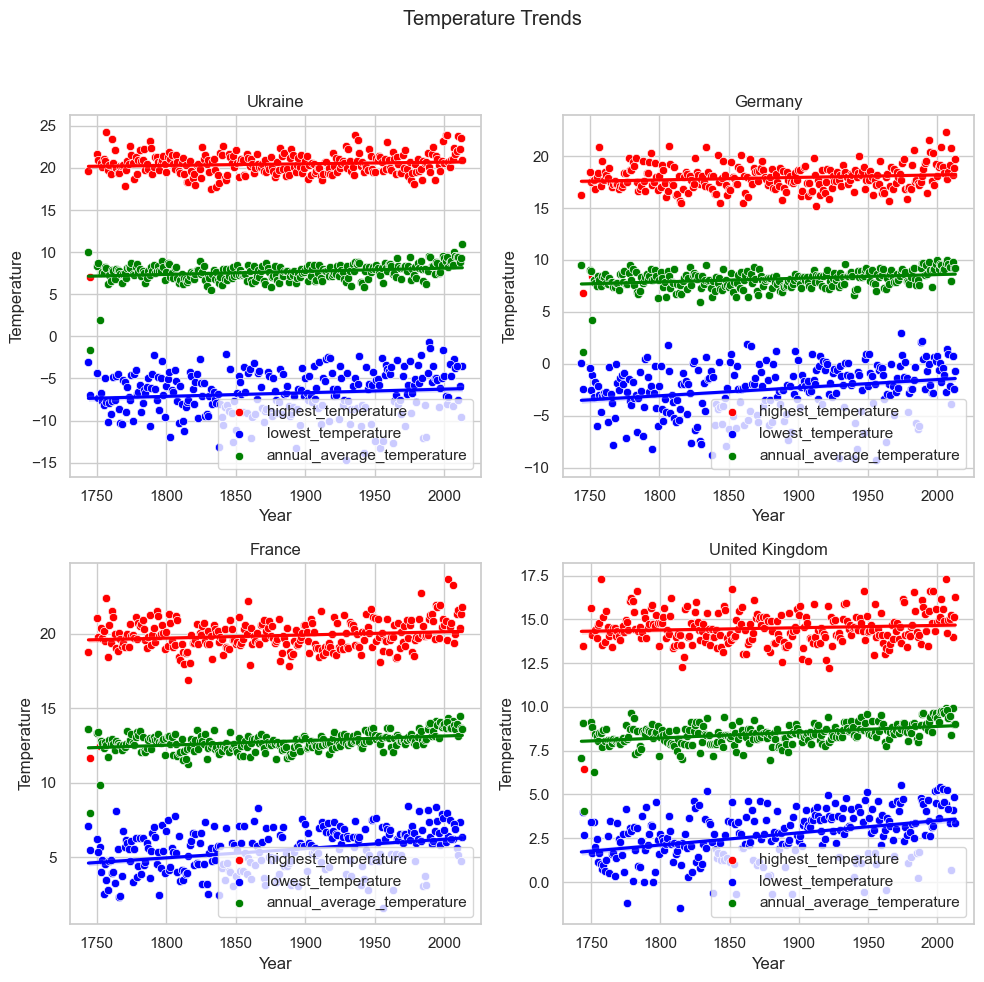

In [58]:
country_plotter(united_data, temperature_categories, country_list, figure_size=(10, 10))


In [91]:
#united_data = remove_outliers(united_data, country_list, list(temperature_categories.keys()))
united_data = united_data.drop(columns=['index'], errors='ignore') \
                       .query('1750 <= year <= 2013') \
                       .reset_index(drop=True)


In [92]:
united_data

,country,year,highest_temperature,lowest_temperature,annual_average_temperature
0,Ukraine,1753,20.610,-6.765,7.525083
1,Ukraine,1754,20.068,-7.715,7.635250
2,Ukraine,1755,21.025,-8.194,7.478250
3,Ukraine,1756,20.796,-5.005,8.235500
4,Ukraine,1758,19.790,-10.233,6.181000
...,...,...,...,...,...
3095,United Kingdom,2008,14.935,4.175,9.348250
3096,United Kingdom,2009,15.040,3.379,9.453333
3097,United Kingdom,2010,15.245,0.711,8.394333
3098,United Kingdom,2012,15.152,4.845,9.037417


In [132]:
model = LinearRegression()

def split_data(df, country_list, temperature_category, random_state=42):
    data_dict = {}
    for country in country_list:
        country_subset = df[df['country'] == country]
        X = country_subset[['year']]
        y = country_subset[temperature_category]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)
        data_dict[country] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
    return data_dict

def split_lin(df, country_list, temperature_category, split_percentage=0.75):
    data_dict = {}
    for country in country_list:
        country_subset = df[df['country'] == country]
        X = country_subset[['year']]
        y = country_subset[temperature_category]
        
        split_index = int(len(X) * split_percentage)
        
        X_train, X_test = X[:split_index], X[split_index:]
        y_train, y_test = y[:split_index], y[split_index:]
        
        data_dict[country] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
    return data_dict


def train_linear_regression(data_dict, temperature_categories):
    regressors = {}

    for country, data in data_dict.items():
        for category in temperature_categories:
            X_train, y_train = data['X_train'], data['y_train']
            try:
                regressor = LinearRegression()
                regressor.fit(X_train, y_train)
                if country not in regressors:
                    regressors[country] = {}
                regressors[country][category] = regressor
            except Exception:
                pass

    return regressors


def test_linear_regression(regressors, temperature_categories, data_dict):
    for country, data in data_dict.items():
        print(f'Temperature Predictions for {country}:')
        for category in temperature_categories:
            if country in regressors and category in regressors[country]:
                regressor = regressors[country][category]
                X_test, y_test = data['X_test'], data['y_test']
                y_pred = regressor.predict(X_test)
                #print(f'{category}:')
                #print(y_pred)


In [134]:
#xy_splits=split_data(united_data,country_list, categories_to_plot,random_state=42)
xy_splits=split_lin(united_data, country_list, categories_to_plot, split_percentage=0.8)
xy_splits

{'Ukraine': {'X_train':      year
  0    1753
  1    1754
  2    1755
  3    1756
  4    1758
  ..    ...
  615  1852
  616  1853
  617  1854
  618  1855
  619  1856
  
  [620 rows x 1 columns],
  'X_test':      year
  620  1857
  621  1858
  622  1859
  623  1860
  624  1861
  ..    ...
  770  2008
  771  2009
  772  2010
  773  2011
  774  2012
  
  [155 rows x 1 columns],
  'y_train':      highest_temperature  lowest_temperature  annual_average_temperature
  0                 20.610              -6.765                    7.525083
  1                 20.068              -7.715                    7.635250
  2                 21.025              -8.194                    7.478250
  3                 20.796              -5.005                    8.235500
  4                 19.790             -10.233                    6.181000
  ..                   ...                 ...                         ...
  615               18.958              -4.679                    7.262833
  616      

In [103]:
list(temperature_categories.keys())

['highest_temperature', 'lowest_temperature', 'annual_average_temperature']

In [135]:
# Train the linear regression models
regressors = train_linear_regression(xy_splits, list(temperature_categories.keys()))


In [140]:
def create_linear_regression_plots(regressors, temperature_categories, data_dict, df, figsize):
    sns.set(style="whitegrid")
    
    for country, data in data_dict.items():
        X_test, y_test = data['X_test'], data['y_test']
        
        for category in temperature_categories:
            if country in regressors and category in regressors[country]:
                regressor = regressors[country][category]
                y_pred = regressor.predict(X_test)
                
                plt.figure(figsize=figsize)
                
                # Scatter plot for the actual data before the "year" in X_test
                country_data_filtered = df[(df['country'] == country) & (df['year'] <= X_test['year'].min())]
                plt.scatter(country_data_filtered['year'], country_data_filtered[category], label=f'{country} Data', color='blue')
                
                # Scatter plot for the test data
                plt.scatter(X_test['year'], y_test, label='Scatter', color='green')  # Use X_test['year'] as x-axis
                plt.plot(X_test['year'], y_pred, label='Prediction', color='red')  # Use X_test['year'] as x-axis
                
                plt.title(f'{country} - {category} Predictions')
                plt.xlabel('Year')
                plt.ylabel(category)
                plt.legend()
                plt.tight_layout()
                plt.show()


ValueError: x and y must be the same size

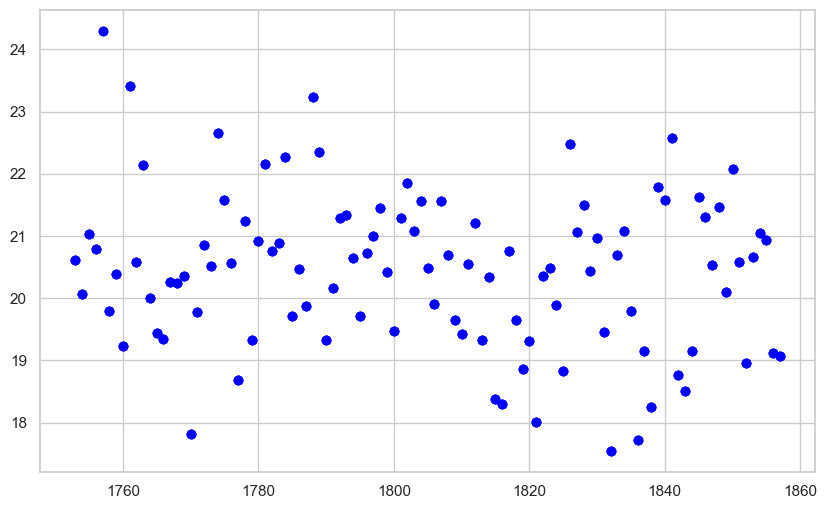

In [141]:
# Create NEW linear regression plots

#united_data,country_list
figsize = (10, 6)
create_linear_regression_plots(regressors, list(temperature_categories.keys()), xy_splits, united_data, figsize)

In [86]:
def create_linear_regression_plots(regressors, df, temperature_categories, country_list, figsize=(10, 4)):
    sns.set(style="whitegrid")
    num_countries = len(country_list)
    num_columns = 2  # Number of columns for plotting
    
    # Calculate the number of rows needed based on the number of countries and columns
    num_rows = (num_countries + 1) // num_columns
    
    for i, country in enumerate(country_list):
        plt.subplot(num_rows, num_columns, i + 1)
        country_data = df[df['country'] == country]
        X_test = country_data[['year']]
        
        for category in temperature_categories:
            if category in regressors:
                y_pred = regressors[category].predict(X_test)
                plt.title(f'Predictions for {category} in {country}')
                sns.lineplot(x=country_data['year'], y=y_pred, label='Predicted', color='red')
                sns.lineplot(x=country_data['year'], y=country_data[category], label='Actual', color='blue')
                plt.xlabel('Year')
                plt.ylabel(category)
                plt.legend()
    
    # Set tight layout for better spacing
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle('Linear Regression Predictions')
    plt.gcf().set_size_inches(figsize)
    plt.show()


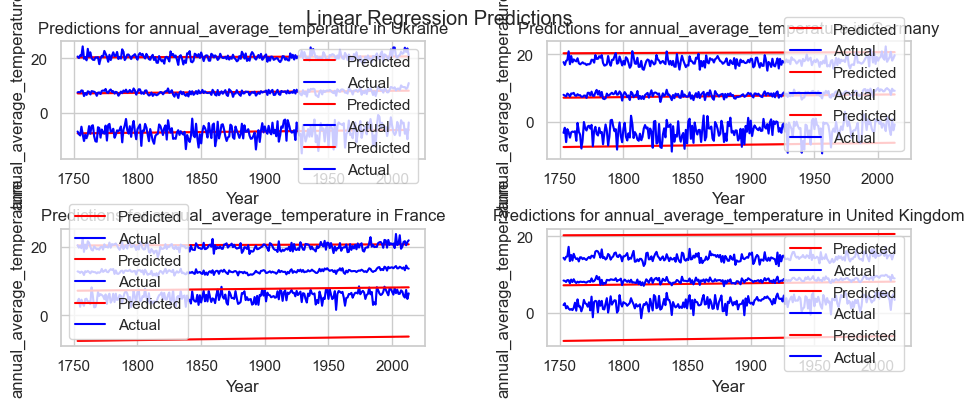

In [87]:
# Create linear regression plots
create_linear_regression_plots(regressors, united_data, list(temperature_categories.keys()), country_list,figsize=(10, 4))

So we cannot use regressor trained for one country ("Ukraine") for other countries, even for same categories.
This makes sense in fact due to different geographical and thus - climate conditions, even though general behaviour seem ok, the free parameter of the offset is to be imroved. Normalization looks best option here - by subtracting the mean avg temp for the country

Prediction for next 50 years

In [94]:
# List of countries and temperature categories
country_list = ['Ukraine', 'France', 'Germany']
temperature_categories = ['highest_temperature', 'lowest_temperature', 'annual_average_temperature'] 

# Create a list of future years for prediction
current_year = 2023  # Replace with the current year
future_years = [current_year + i for i in range(1, 51)]  # Next 50 years
def train_linear_regression(df, country, category):
    country_data = df[df['country'] == country]
    X_train = country_data[['year']]
    y_train = country_data[category]
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    return regressor

def test_linear_regression(regressors, future_df, temperature_categories, country_list):
    future_years = np.arange(future_df['year'].min(), future_df['year'].max() + 1 + 50)
    
    for category in temperature_categories:
        for country in country_list:
            if (country, category) in regressors:
                regressor = regressors[(country, category)]
                X_test = future_years.reshape(-1, 1)
                y_pred = regressor.predict(X_test)
                future_df[f'{country} - {category}'] = y_pred

def create_linear_regression_plots(df, temperature_categories, country_list):
    sns.set(style="whitegrid")
    for category in temperature_categories:
        plt.figure(figsize=(12, 6))
        plt.title(f'Predictions for {category} Over the Next 50 Years')
        
        for country in country_list:
            column_name = f'{country} - {category}'
            plt.plot(df['year'], df[column_name], label=country)
        
        plt.xlabel('Year')
        plt.ylabel(category)
        plt.legend()
        plt.tight_layout()
    
    plt.show()

In [95]:
future_df=pd.DataFrame(united_data, columns=column_names)


In [96]:
future_df.head

<bound method NDFrame.head of               country  year  highest_temperature  lowest_temperature  \
42941         Ukraine  1744               19.673              -3.092   
42943         Ukraine  1750               21.606              -4.372   
42944         Ukraine  1751               20.916              -7.272   
42946         Ukraine  1753               20.610              -6.765   
42947         Ukraine  1754               20.068              -7.715   
...               ...   ...                  ...                 ...   
43627  United Kingdom  2008               14.935               4.175   
43628  United Kingdom  2009               15.040               3.379   
43629  United Kingdom  2010               15.245               0.711   
43631  United Kingdom  2012               15.152               4.845   
43632  United Kingdom  2013               16.260               3.351   

       annual_average_temperature  
42941                    9.997125  
42943                    8.390818

In [91]:
regressors = {}
for country in country_list:
    for category in temperature_categories:
        regressor = train_linear_regression(future_df, country, category)
        regressors[(country, category)] = regressor


In [101]:
def test_linear_regression(regressors, df, temperature_categories, country_list):
    # Create a list of future years for prediction
    future_years = np.arange(df['year'].max() + 1, df['year'].max() + 51)

    for category in temperature_categories:
        for country in country_list:
            if (country, category) in regressors:
                regressor = regressors[(country, category)]
                X_test = future_years.reshape(-1, 1)
                y_pred = regressor.predict(X_test)

                # Create a DataFrame for predictions and add it to the original DataFrame
                column_name = f'{country}_{category}'
                predictions_df = pd.DataFrame({'year': future_years, column_name: y_pred})
                df = pd.concat([df, predictions_df], ignore_index=True)

    return df

In [102]:
future_df_with_predictions = test_linear_regression(regressors, future_df, temperature_categories, country_list)


C:\Users\IGloc\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\IGloc\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\IGloc\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\IGloc\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\IGloc\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\IGloc\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not ha

In [ ]:
# Create linear regression plots
create_linear_regression_plots(future_df_with_predictions, temperature_categories, country_list)

Augmented Dickey-Fuller (ADF) statistics is widely used statistical test to check whether the time series is stationary or not.
It uses an autoregressive model and optimizes an information criterion across multiple different lag values.
Null Hypothesis: Series is not stationary.
Alternate Hypothesis: Series is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','No. of Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
adf_test(data)

p-value < 0.05 (significance) - indicating the data is stationary, therefore we reject the null hypothesis.

KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test is a statistical test to check for stationarity of a series around a deterministic trend. KPSS test figures out if a time series is stationary around a mean or linear trend or is non-stationary due to a unit root.

Null Hypothesis: The series is trend stationary.
Alternate Hypothesis: The series is not stationary.

In [ ]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression = 'c', nlags = 'legacy')
    kpss_output = pd.Series(kpsstest[0:3], index = ['Test Statistic','p-value','No. of Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
kpss_test(data)

The p-value is greater than the level of significance (0.05) and hence it is weak evidence against the null hypothesis and therefore we fail to reject the null hypothesis. This indicates that our time series is stationary.

Both ADF and KPSS tests are in agreement that the time series data is stationary.

Assigning Frequency to the Time Series Data:
We resample the data with 'MS' (Month Start) as the frequency. Although the data already consisted of only monthly samples, resampling it this way assigns a frequency to it. Frequency ambiguity could lead to the SARIMAX model auto-assigning the frequency which should be avoided.

In [ ]:
y = data['AverageTemperature'].resample('MS').mean()
y.head()

In [ ]:
#Train and Test Splits:¶
train = y[:'2009']
test = y['2010':]